In [1]:
import utility as ut
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from datetime import datetime
import math

In [2]:
# File paths
DIRECTORY = "data/"
GANTRY_CRANE_PARAMETERS_JSON_PATH = "gantry_crane_parameters.json"
RESULTS_PATH = "FPA_results/"

In [3]:
# Load data
datasets = ut.load_excel_data(DIRECTORY)

In [4]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

In [5]:
interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_speed = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position_first_derivative"]
    )
    new_cable_speed = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length_first_derivative"]
    )
    new_trolley_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_trolley_motor"]
    )
    new_hoist_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_hoist_motor"]
    )
    new_trolley_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_motor_voltage"]
    )
    new_hoist_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["hoist_motor_voltage"]
    )

    interpolated_df = {
        "time": time_array,
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_speed": new_trolley_speed,
        "cable_speed": new_cable_speed,
        "trolley_motor_pwm": new_trolley_motor_pwm,
        "hoist_motor_pwm": new_hoist_motor_pwm,
        "trolley_motor_voltage": new_trolley_motor_voltage,
        "hoist_motor_voltage": new_hoist_motor_voltage,
    }

    interpolated_datasets.append(interpolated_df)

print(len(interpolated_datasets))


39


In [6]:
max_sway_angle = 0
for i in range(len(interpolated_datasets)):
    max_sway_angle = max(
        max_sway_angle, max(abs(interpolated_datasets[i]["sway_angle"]))
    )

# Sort the interpolated_datasets by average trolley motor PWM from lowest to highest and then by average hoist motor PWM from lowest to highest
interpolated_datasets.sort(key=lambda x: np.mean(x["trolley_motor_pwm"]))
interpolated_datasets.sort(key=lambda x: np.mean(x["hoist_motor_pwm"]))

for key in interpolated_datasets[0]:
    print(key)

time
trolley_position
cable_length
sway_angle
trolley_speed
cable_speed
trolley_motor_pwm
hoist_motor_pwm
trolley_motor_voltage
hoist_motor_voltage


In [7]:
USE_BEST_DATASET = True
best_dataset = []
if USE_BEST_DATASET:
    for index in range(len(interpolated_datasets)):
        if (index >= 9 and index <= 20) or (index >= 30):
            continue
        best_dataset.append(interpolated_datasets[index])
    
    interpolated_datasets = best_dataset
print(len(interpolated_datasets))

18


In [8]:
SHOW_INTERPOLATED_PLOT = False
if SHOW_INTERPOLATED_PLOT:
    for index, interpolated_dataset in enumerate(interpolated_datasets):
        # if (index >= 9 and index <= 20) or (index >= 30):
        #     continue
        # Create a figure and a set of subplots
        figure, ax = plt.subplots(4, 2, figsize=(14, 9), sharex=True)
        figure.suptitle(f"Interpolated Dataset {index+1}", fontsize=16)
        ut.add_to_subplot(ax[0, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_motor_pwm"], ylabel="PWM motor troli", color="blue")
        ut.add_to_subplot(ax[0, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["hoist_motor_pwm"], ylabel="PWM motor angkut", color="red")
        ut.add_to_subplot(ax[1, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_motor_voltage"], ylabel="Tegangan motor troli (V)", color="blue")
        ut.add_to_subplot(ax[1, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V)", color="red")
        ut.add_to_subplot(ax[2, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_position"], ylabel="Posisi troli (m)", color="green")
        ut.add_to_subplot(ax[2, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_speed"], ylabel="Kecepatan troli (m/s)", color="green", linestyle="--")
        ut.add_to_subplot(ax[2, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["cable_length"], ylabel="Panjang tali (m)", color="orange")
        ut.add_to_subplot(ax[2, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["cable_speed"], ylabel="Kecepatan tali (m/s)", color="orange", linestyle="--")
        ut.add_to_subplot(ax[3, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["sway_angle"], "Waktu (s)", "Sudut ayun (°)", "purple")
        ut.add_to_subplot(ax[3, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["sway_angle"], "Waktu (s)", "Sudut ayun (°)", "purple")
        ax[3, 0].set_ylim(-max_sway_angle, max_sway_angle)
        ax[3, 1].set_ylim(-max_sway_angle, max_sway_angle)
        plt.tight_layout()
        plt.show()

In [9]:
# Open gantry crane parameter json file
USE_LAST_BEST_PARAMETERS = False
if USE_LAST_BEST_PARAMETERS:
    all_gantry_crane_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")
else:
    all_gantry_crane_parameters = ut.load_json(GANTRY_CRANE_PARAMETERS_JSON_PATH)["gantry_crane_system_model"]["parameters"]
print(all_gantry_crane_parameters)

{'trolley_motor_torque_constant': {'value': 0.001, 'unit': 'Nm/A', 'description': 'Torque constant of the trolley motor', 'measured': False}, 'trolley_motor_back_emf_constant': {'value': 0.001, 'unit': 'V/(rad/s)', 'description': 'Back EMF constant of the trolley motor', 'measured': False}, 'trolley_motor_rotator_inertia': {'value': 0.001, 'unit': 'kg.m^2', 'description': 'Rotational inertia of the trolley motor rotor', 'measured': False}, 'trolley_motor_damping_coefficient': {'value': 0.001, 'unit': 'Ns.m/rad', 'description': 'Damping coefficient of the trolley motor', 'measured': False}, 'trolley_damping_coefficient': {'value': 0.001, 'unit': 'Ns/m', 'description': 'Damping coefficient of the trolley', 'measured': False}, 'hoist_motor_back_emf_constant': {'value': 0.1, 'unit': 'V/(rad/s)', 'description': 'Back EMF constant of the hoist motor', 'measured': False}, 'hoist_motor_rotator_inertia': {'value': 0.001, 'unit': 'kg.m^2', 'description': 'Rotational inertia of the hoist motor ro

In [10]:
measured_parameters = {}
approximated_parameters = {}
for parameter in all_gantry_crane_parameters:
    if all_gantry_crane_parameters[parameter]["measured"]:
        measured_parameters[parameter] = all_gantry_crane_parameters[parameter]
    else:
        approximated_parameters[parameter] = all_gantry_crane_parameters[parameter]

# Print header of approximated parameters
print("Approximated Parameters")
print("Name", "Value")
for parameter in approximated_parameters:
    print(parameter, approximated_parameters[parameter]["value"])

Approximated Parameters
Name Value
trolley_motor_torque_constant 0.001
trolley_motor_back_emf_constant 0.001
trolley_motor_rotator_inertia 0.001
trolley_motor_damping_coefficient 0.001
trolley_damping_coefficient 0.001
hoist_motor_back_emf_constant 0.1
hoist_motor_rotator_inertia 0.001
hoist_motor_torque_constant 10.001
hoist_motor_damping_coefficient 0.001
cable_damping_coefficient 0.001


In [11]:
# for parameter in all_gantry_crane_parameters:
# #     # Continue if parameter have "trolley_*" or "hoist_*" in its name
#     # if "trolley_" in parameter:
#     #     continue
#     if "hoist_" in parameter or "cable_" in parameter:
#         continue
#     if parameter in approximated_parameters:
#         approximated_parameters.pop(parameter)

for parameter in approximated_parameters:
    print(parameter)

trolley_motor_torque_constant
trolley_motor_back_emf_constant
trolley_motor_rotator_inertia
trolley_motor_damping_coefficient
trolley_damping_coefficient
hoist_motor_back_emf_constant
hoist_motor_rotator_inertia
hoist_motor_torque_constant
hoist_motor_damping_coefficient
cable_damping_coefficient


In [12]:
from model import Simulator
simulator = Simulator(DT, NUM_STEPS)

In [13]:
def cost_function(parameter, datasets):
    # NUMBER_OF_DATASETS = len(datasets)
    average_sum_RMSE_squared = 0
    for dataset in datasets:
        trolley_motor_input = dataset["trolley_motor_pwm"]
        hoist_motor_input = dataset["hoist_motor_pwm"]
        initial_conditions = {
            "x" : dataset["trolley_position"][0],
            "l" : dataset["cable_length"][0],
            "theta" : dataset["sway_angle"][0],
        }
        simulator.simulate(parameter, trolley_motor_input, hoist_motor_input, initial_conditions=initial_conditions)
        simulation_result = simulator.get_results()

        simulation_result_array = [simulation_result[key] for key in simulation_result]
        dataset_array = [dataset[key] for key in dataset]

        sum_RMSE = ut.calculate_sum_root_mean_squared_errors(simulation_result_array, dataset_array)
        
        if np.isnan(sum_RMSE):
            return np.inf
        
        average_sum_RMSE_squared += sum_RMSE**2
    
    # average_sum_RMSE_squared /= NUMBER_OF_DATASETS
    
    return average_sum_RMSE_squared

In [14]:
optimize_range = {
    "trolley_mass": (0.001, 10.0),  # Done
    "trolley_damping_coefficient": (0.001, 10.0),  # Done
    "cable_damping_coefficient": (0.001, 10.0),  # Done
    "trolley_motor_rotator_inertia": (0.001, 10.0),  # Done
    "trolley_motor_damping_coefficient": (0.001, 10.0),
    "trolley_motor_back_emf_constant": (0.001, 10.0),  # Done
    "trolley_motor_torque_constant": (0.001, 10.0),  # Done
    "hoist_motor_rotator_inertia": (0.001, 10.0),  # Done
    "hoist_motor_damping_coefficient": (0.001, 10.0), # Done
    "hoist_motor_back_emf_constant": (0.001, 10.0),  # Done
    "hoist_motor_torque_constant": (0.001, 10.0),  # Done
    "trolley_motor_activation_threshold_voltage": (0.001, 10.0),  # Done
    "hoist_motor_activation_threshold_voltage": (0.001, 10.0),  # Done
}

In [15]:
MAX_EPISODES = 3
MAX_GENERATIONS = 20
NUMBER_OF_POPULATIONS = 3
SWITCH_PROBABILITY = 0.8
LAMBDA = 1.5
NUMBER_OF_PARAMETERS = len(approximated_parameters)
# NUMBER_OF_PARAMETERS = 10
BATCH_SIZE = len(interpolated_datasets)



In [16]:
def Levy_flight(Lambda):
    step_size = np.zeros(NUMBER_OF_PARAMETERS)
    # Levy flight
    sigma = (math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) / (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    for i in range(NUMBER_OF_PARAMETERS):
        u = np.random.normal(0, sigma)
        v = np.random.normal(0, 1)
        step = u / np.abs(v) ** (1 / Lambda)
        step_size[i] = step
    return step_size

In [17]:
random_dataset_indexes = random.sample(range(len(interpolated_datasets)), BATCH_SIZE)
random_datasets = [interpolated_datasets[index] for index in random_dataset_indexes]

In [18]:
for episode in range(MAX_EPISODES):
    # Generate new population_of_parameters
    print(f"\033[92mCreating new population for episode {episode+1}.\033[0m Population size: {NUMBER_OF_POPULATIONS}")
    population_of_parameters = []
    for i in range(NUMBER_OF_POPULATIONS):
        new_parameters = copy.deepcopy(all_gantry_crane_parameters)
        for parameter in approximated_parameters:
            new_parameters[parameter]["value"] = np.random.uniform(optimize_range[parameter][0], optimize_range[parameter][1])
        population_of_parameters.append(new_parameters)
        
    # Find best cost in population_of_parameters
    print(f"\033[92mFinding initial best cost for episode {episode+1}.\033[0m", end=" ")
    costs = np.zeros(NUMBER_OF_POPULATIONS)
    for index, parameters in enumerate(population_of_parameters):
        costs[index] = cost_function(parameters, random_datasets)
    
    best_parameters_index = np.argmin(costs)
    best_cost = costs[best_parameters_index]
    best_parameters = population_of_parameters[best_parameters_index]
    print(f"Initial best cost: {best_cost}")



    for generation in range(MAX_GENERATIONS):
        for index, parameters in enumerate(population_of_parameters):
            # Generate temporary parameters
            new_parameters = copy.deepcopy(parameters)
            polination_type = ""
            if np.random.uniform(0, 1) < SWITCH_PROBABILITY:
                polination_type = "global"
                # Do global pollination
                Levy_step = Levy_flight(LAMBDA)
                step_size = Levy_step
                for index_, parameter in enumerate(approximated_parameters):
                    new_parameters[parameter]["value"] += step_size[index_] * (parameters[parameter]["value"] - best_parameters[parameter]["value"])
                    
            else:
                polination_type = "local"
                # Do local pollination
                epsilon = np.random.uniform(0, 1)
                step_size = epsilon
                j, k = random.sample(range(NUMBER_OF_POPULATIONS), 2)
                for i, parameter in enumerate(approximated_parameters):
                    new_parameters[parameter]["value"] += step_size * (population_of_parameters[j][parameter]["value"] - population_of_parameters[k][parameter]["value"])
            
            # Check if new_parameters is within the range
            for parameter in approximated_parameters:
                if new_parameters[parameter]["value"] < optimize_range[parameter][0]:
                    new_parameters[parameter]["value"] = optimize_range[parameter][0]
                elif new_parameters[parameter]["value"] > optimize_range[parameter][1]:
                    new_parameters[parameter]["value"] = optimize_range[parameter][1]
            
            # Evaluate new_parameters
            new_cost = cost_function(new_parameters, random_datasets)
            if new_cost == np.inf:
                print(f"Population {index+1} has inf cost. Generating new random parameters for population {index+1}")
                for parameter in approximated_parameters:
                    new_parameters[parameter]["value"] = np.random.uniform(optimize_range[parameter][0], optimize_range[parameter][1])
                new_cost = cost_function(new_parameters, random_datasets)
            
            if new_cost < costs[index]:
                population_of_parameters[index] = new_parameters
                costs[index] = new_cost
                
            if new_cost < best_cost:
                print(f"\033[92mFound new best cost: {new_cost}.\033[0m", end=" Parameters: ")
                for parameter in best_parameters:
                    print(parameter, best_parameters[parameter]["value"], end=", ")
                print()
                best_cost = new_cost
                best_parameters = new_parameters
                ut.save_json(best_parameters, RESULTS_PATH + "best_parameters.json")
            
            print(f"Episode {episode+1} of {MAX_EPISODES}, Generation {generation+1} of {MAX_GENERATIONS}, Population {index+1}, Polination type: {polination_type}, Cost: {costs[index]}")
            if (generation+1) % int(MAX_GENERATIONS/10) == 0:
                print(f"\033[92mCheckpoint: Episode {episode+1}, Generation {generation+1}, Best Cost: {best_cost} \033[0m")
                for parameter in best_parameters:
                    print(parameter, best_parameters[parameter]["value"], end=", ")
                print()

Creating new population for episode 1. Population size: 3
Finding initial best cost for episode 1. Initial best cost: 7.680429440868204
Episode 1 of 3, Generation 1 of 20, Population 1, Polination type: local, Cost: 7.680429440868204
Episode 1 of 3, Generation 1 of 20, Population 2, Polination type: global, Cost: 16.982787289820163
Episode 1 of 3, Generation 1 of 20, Population 3, Polination type: global, Cost: 14.128080367865438
Episode 1 of 3, Generation 2 of 20, Population 1, Polination type: global, Cost: 7.680429440868204
Checkpoint: Episode 1, Generation 2, Best Cost: 7.680429440868204 
trolley_motor_torque_constant 9.466344360965074, trolley_motor_back_emf_constant 0.2555108570568796, trolley_motor_rotator_inertia 6.144674131565393, trolley_motor_damping_coefficient 6.547822657829826, trolley_damping_coefficient 7.3538570785900985, hoist_motor_back_emf_constant 5.551788032574123, hoist_motor_rotator_inertia 4.616550720949446, hoist_motor_torque_constant 1.493021030307938, hoist_

KeyboardInterrupt: 

In [ ]:
# parameters_cost_histories = {}
# for index, parameter in enumerate(approximated_parameters):
#     print(f"\033[92mOptimizing parameter: {parameter}. {index + 1} of {NUMBER_OF_PARAMETERS} \033[0m")
#     cost_histories = []
#     for episode in range(MAX_EPISODES):
#         print(f"\033[92mStart episode {episode + 1} of {MAX_EPISODES} \033[0m")
#         current_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")
#         if episode > 0:
#             for parameter_ in approximated_parameters:
#                 current_parameters[parameter_]["value"] = random.uniform(optimize_range[parameter_][0], optimize_range[parameter_][1])

#         last_parameters = copy.deepcopy(current_parameters)
#         parameters_momentum = copy.deepcopy(current_parameters)
#         for parameter_ in parameters_momentum:
#             parameters_momentum[parameter_]["value"] = 0
        
#         diverge = False
#         clipped_counter = 0
#         small_momentum_counter = 0
#         cost_history = np.zeros(MAX_ITERATIONS)
#         for iteration in range(MAX_ITERATIONS):
#             # Choose random datasets for stochastic gradient descent
#             random_dataset_indexes = random.sample(range(len(interpolated_datasets)), BATCH_SIZE)
#             random_datasets = [interpolated_datasets[index] for index in random_dataset_indexes]

#             batch_cost = cost_function(current_parameters, random_datasets)

#             if batch_cost == np.inf:
#                 diverge = True
#                 parameter_value = current_parameters[parameter]["value"]
#                 print(f"\033[91mCost is infinite at iteration {iteration}, parameter: {parameter} = {parameter_value} \033[0m", " " * 100)
#                 break

#             # Calculate the gradient
#             current_parameters[parameter]["value"] = current_parameters[parameter]["value"] + h
#             new_batch_cost = cost_function(current_parameters, random_datasets)
#             gradient = (new_batch_cost - batch_cost) / h
#             current_parameters[parameter]["value"] = current_parameters[parameter]["value"] - h

#             # Update the momentum
#             temp_momentum = parameters_momentum[parameter]["value"]
#             parameters_momentum[parameter]["value"] = GAMMA * temp_momentum + LEARNING_RATE * gradient
            
#             # Update the parameter
#             temp_parameter = current_parameters[parameter]["value"]
#             if abs(parameters_momentum[parameter]["value"]) < 0.01 * optimize_range[parameter][0]:
#                 small_momentum_counter += 1
#                 if small_momentum_counter > 10:
#                     print(f"\033[91mMomentum is too small. Starting new episode.\033[0m", " " * 100)
#                     break
#             current_parameters[parameter]["value"] -= parameters_momentum[parameter]["value"]
#             # current_parameters[parameter]["value"] -= LEARNING_RATE * gradient
            
#             # Clip the parameter
#             current_parameters[parameter]["value"] = np.clip(
#                 current_parameters[parameter]["value"],
#                 optimize_range[parameter][0],
#                 optimize_range[parameter][1],
#             )

#             if current_parameters[parameter]["value"] == optimize_range[parameter][0] or current_parameters[parameter]["value"] == optimize_range[parameter][1]:
#                 clipped_counter += 1
#                 if clipped_counter > 10:
#                     print(f"\033[91mParameter clipped. Starting new episode.\033[0m", " " * 100)
#                     break


#             if last_parameters[parameter]["value"] == current_parameters[parameter]["value"]:
#                 # parameters_momentum[parameter]["value"] = temp_momentum
#                 current_parameters[parameter]["value"] = temp_parameter

#             last_parameters[parameter]["value"] = current_parameters[parameter]["value"]

#             value = current_parameters[parameter]["value"]
#             momentum = parameters_momentum[parameter]["value"]
#             print(f"\033[92mIteration {iteration + 1} of {MAX_ITERATIONS}\033[0m", f"Parameter: {parameter}. Value: {value}. Cost: {batch_cost}. Gradient: {gradient}.  Momentum: {momentum}", " " * 100)

#             # Calculate the cost
#             cost = cost_function(current_parameters, random_datasets)
#             cost_history[iteration] = cost

#             if cost < best_cost:
#                 best_cost = cost
#                 best_parameters = copy.deepcopy(current_parameters)
#                 # Save the best parameters to a JSON file
#                 print(f"\033[92mNew best cost found.\033[0m", "Best cost: ", best_cost, " " * 100)
#                 for parameter_ in best_parameters:
#                     print(parameter_, best_parameters[parameter_]["value"], end=", ")
#                 print()
#                 # Add date and time to the best_parameters
#                 # best_parameters["last_update"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#                 ut.save_json(best_parameters, RESULTS_PATH + "best_parameters.json")

#             if (iteration + 1) % int(MAX_ITERATIONS/8) == 0:
#                 print(f"\033[92mCheckpoint. Parameter: {parameter} {index + 1} of {NUMBER_OF_PARAMETERS}. Episode {episode + 1} of {MAX_EPISODES} \033[0m Best cost: {best_cost}", "Best parameters: ", best_parameters)

#             if diverge:
#                 print(f"\033[91mDiverge. Starting new episode.\033[0m", " " * 100)
#                 break
        
#         cost_histories.append(cost_history)    
#     parameters_cost_histories[parameter] = cost_histories

In [ ]:
# for parameter in parameters_cost_histories:
#     cost_histories = parameters_cost_histories[parameter]
#     for episode, cost in enumerate(cost_histories):
#         plt.plot(cost, label=f"Episode {episode + 1}")
#     plt.title(f"Cost History of Parameter {parameter}")
#     plt.xlabel("Iteration")
#     plt.ylabel("Cost")
#     plt.legend()
#     plt.show()

trolley_motor_torque_constant 10.0, trolley_motor_back_emf_constant 1.0118917371238834, trolley_motor_rotator_inertia 10.0, trolley_motor_damping_coefficient 0.001, trolley_damping_coefficient 0.9375897666769779, hoist_motor_back_emf_constant 0.001, hoist_motor_rotator_inertia 6.550096043683821, hoist_motor_torque_constant 10.0, hoist_motor_damping_coefficient 0.001, cable_damping_coefficient 0.001, trolley_motor_activation_threshold_voltage 3.0, hoist_motor_activation_threshold_voltage 3.0, trolley_mass 2.0, container_mass 1.128, gravity_acceleration 9.81, hoist_motor_inductance 0.0073, hoist_motor_resistance 9.5, hoist_motor_pulley_radius 0.0075, trolley_motor_inductance 0.0001048, trolley_motor_resistance 0.39, trolley_motor_pulley_radius 0.0075, 


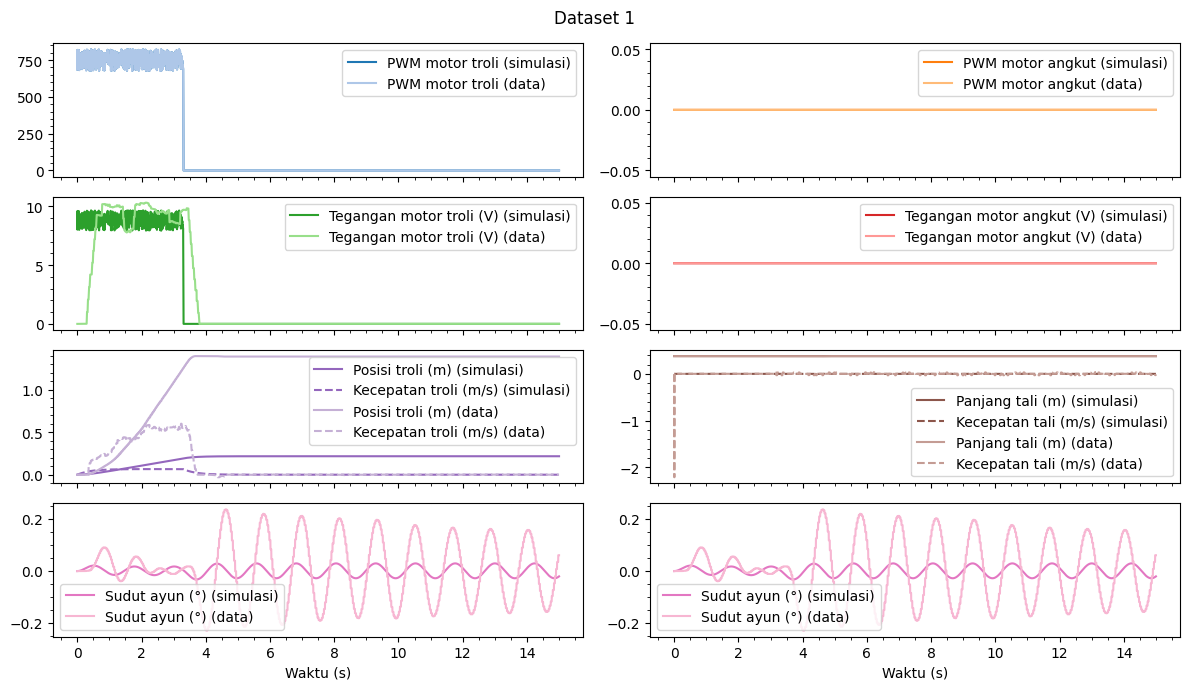

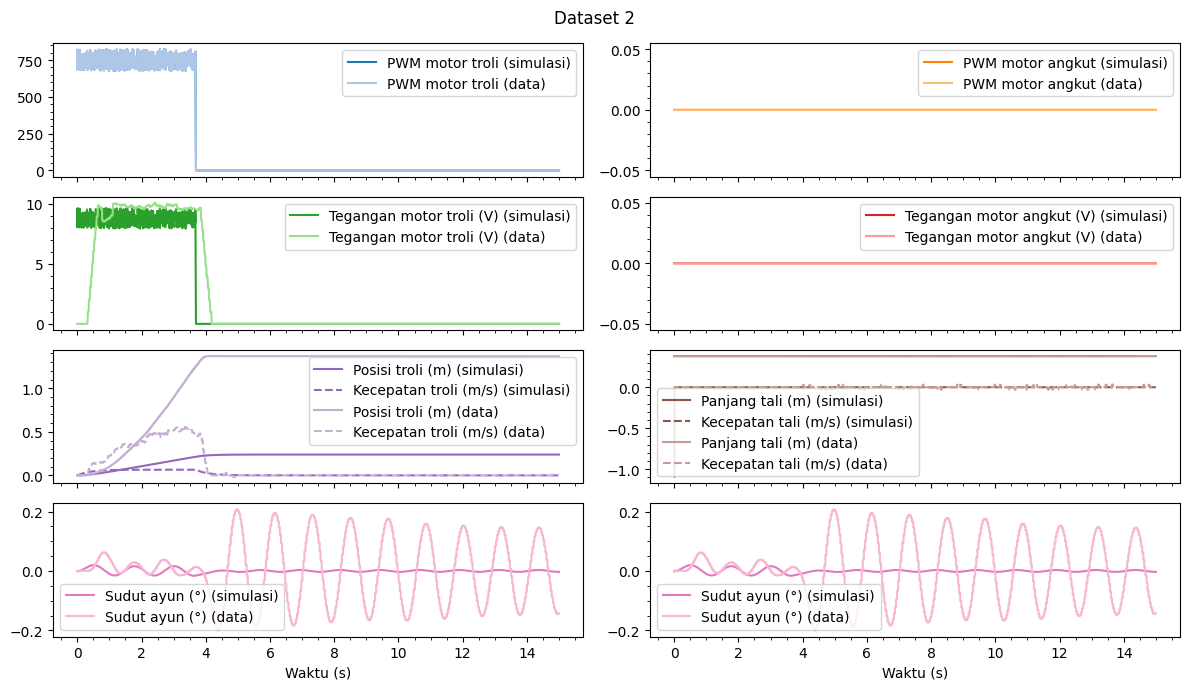

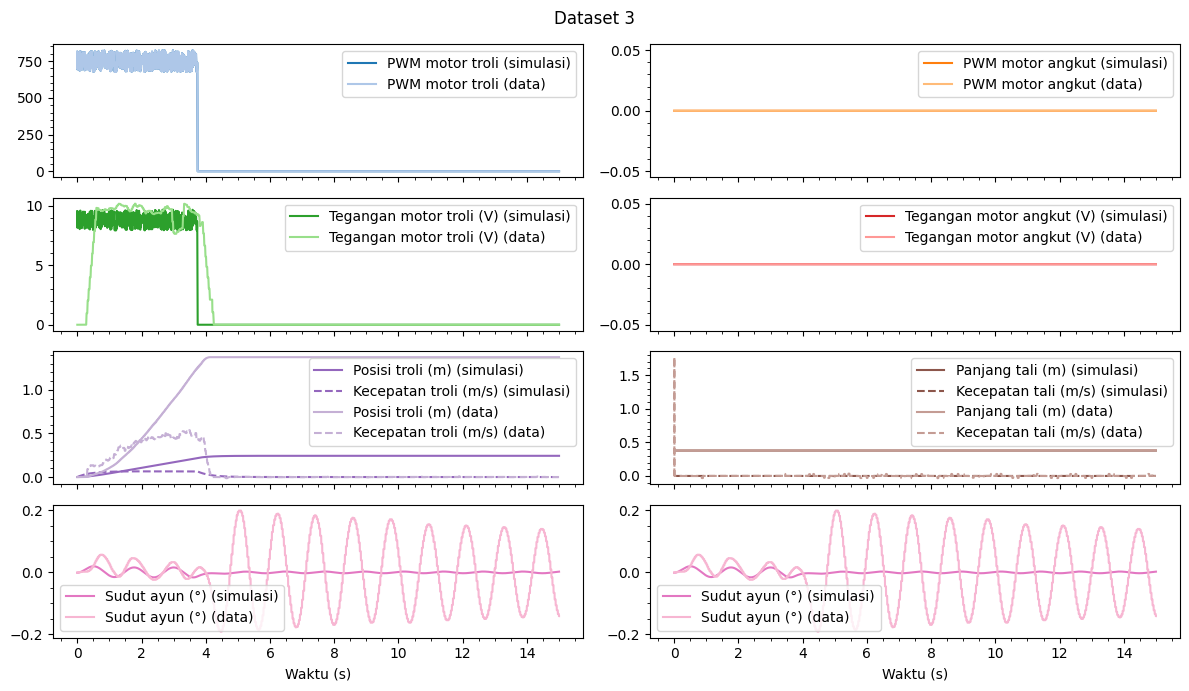

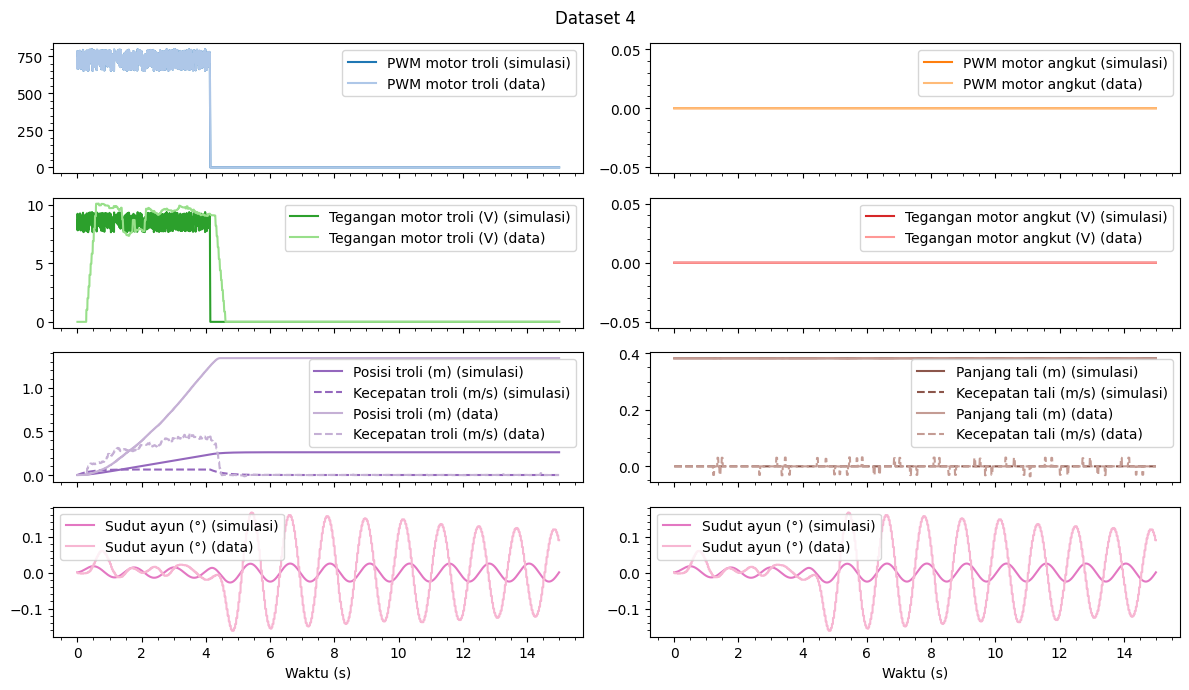

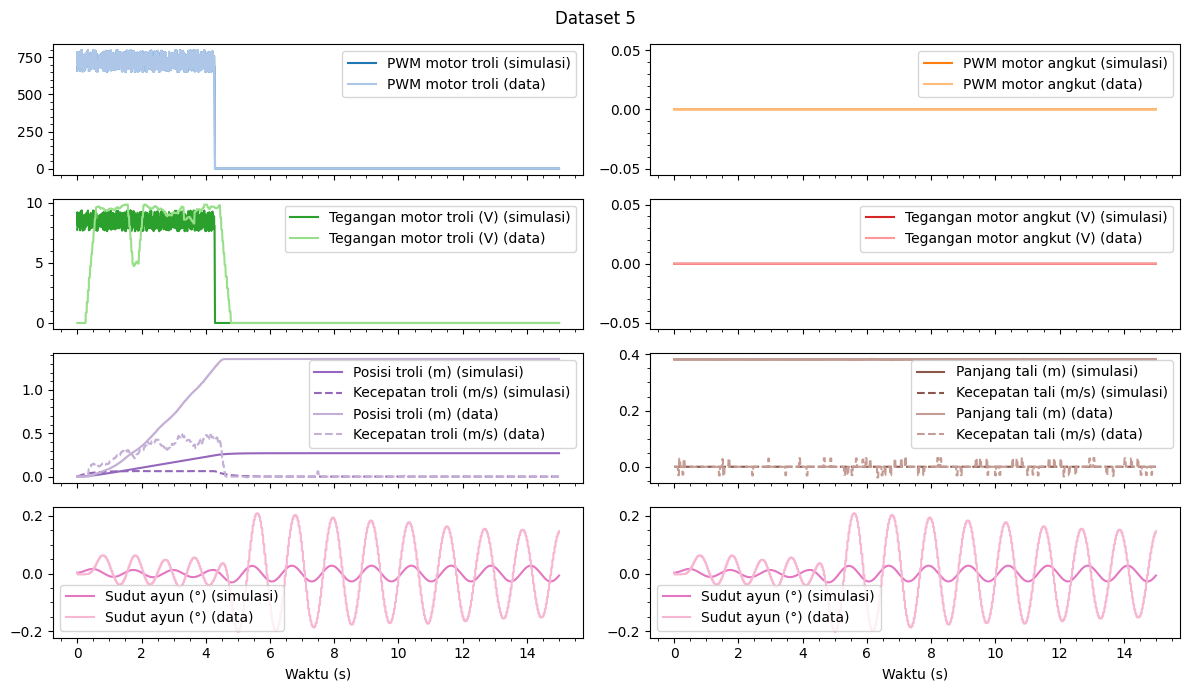

C:\Users\Cristian\AppData\Local\Temp\ipykernel_6764\3813457765.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


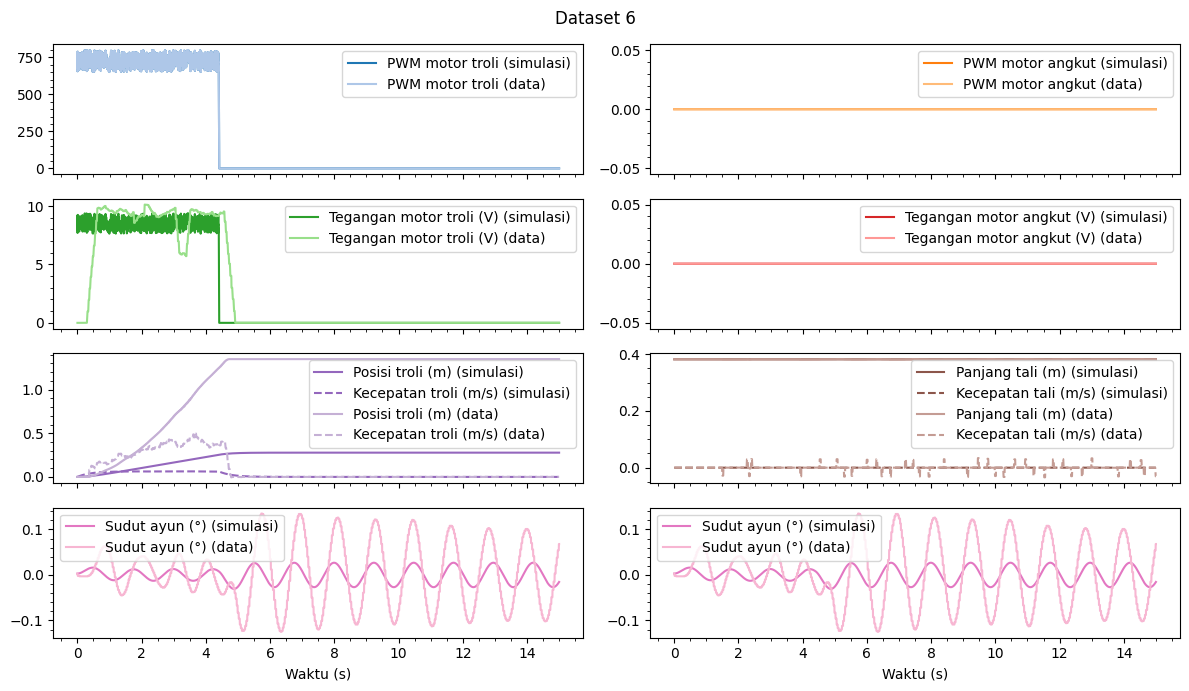

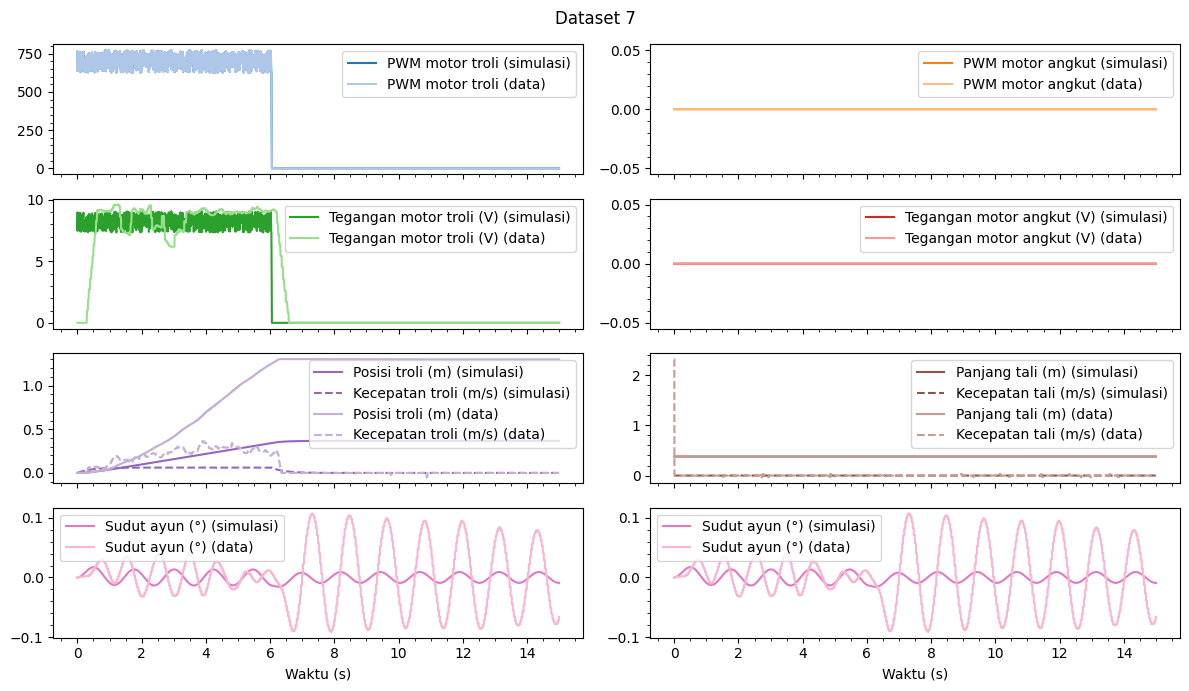

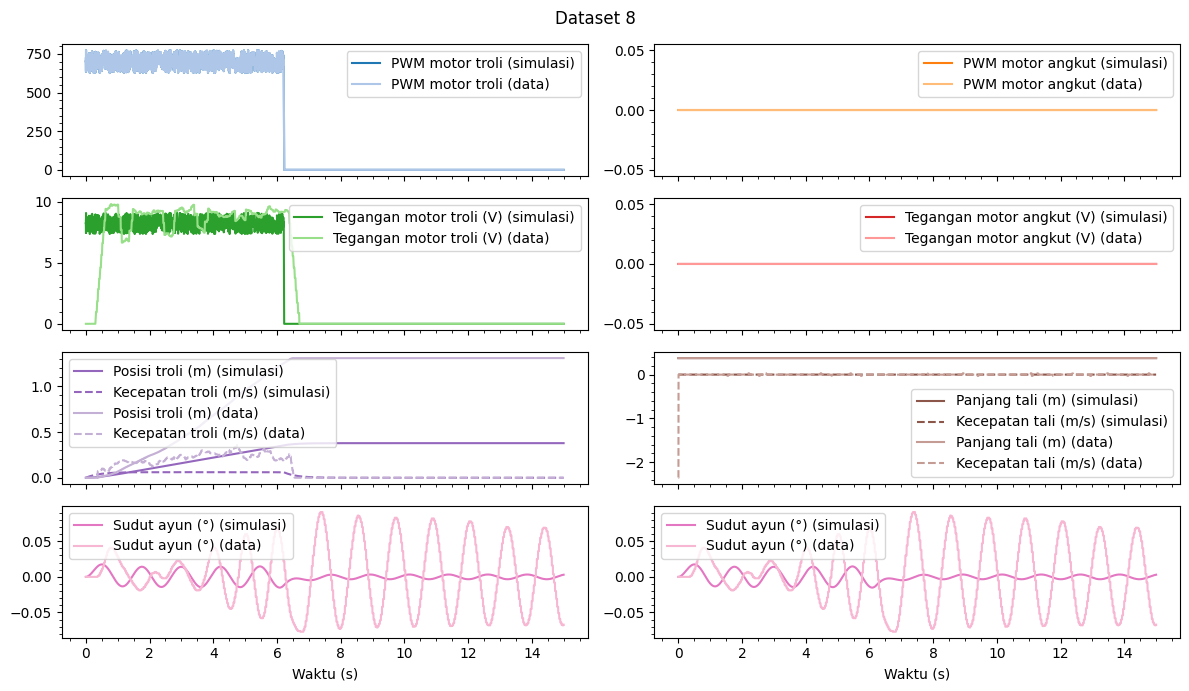

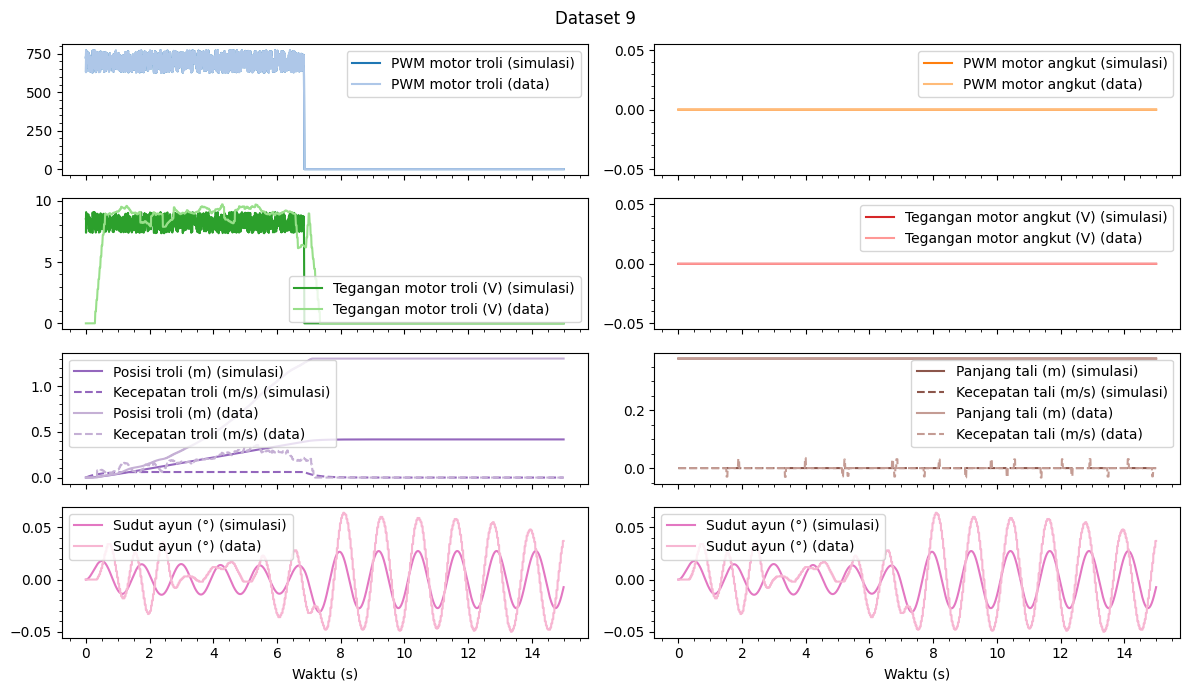

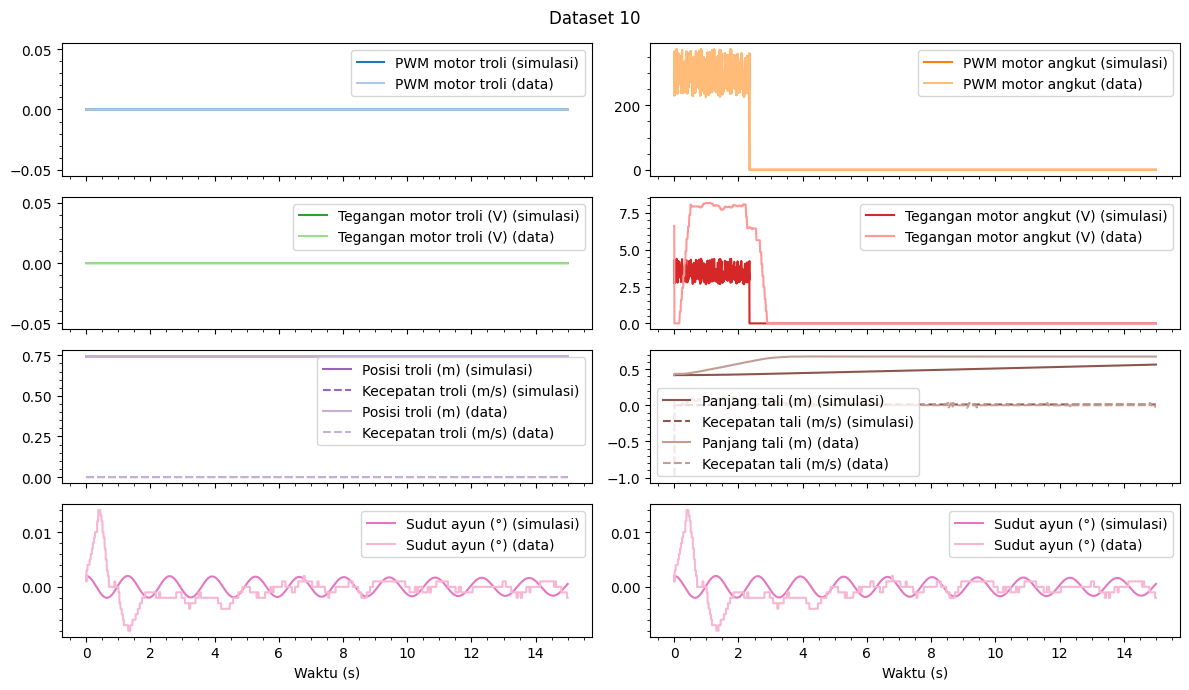

KeyboardInterrupt: 

In [ ]:
# Load the best parameters

best_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")

# best_parameters = ut.load_json(GANTRY_CRANE_PARAMETERS_JSON_PATH)["gantry_crane_system_model"]["parameters"]

for parameter in best_parameters:
    print(parameter, best_parameters[parameter]["value"], end=", ")
print()

# Simulate the gantry crane system using the best parameters
for index, dataset in enumerate(interpolated_datasets):
    # if index != 0:
    #     continue
    # if index != 10:
    #     continue
    simulator.simulate(best_parameters, dataset["trolley_motor_pwm"], dataset["hoist_motor_pwm"], initial_conditions={"x": dataset["trolley_position"][0], "l": dataset["cable_length"][0], "theta": dataset["sway_angle"][0]})
    simulation_result = simulator.get_results()

    # Create a figure and a set of subplots
    figure, ax = plt.subplots(4, 2, figsize=(12, 7), sharex=True)
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(f"Dataset {index+1}")
    ut.add_to_subplot(ax[0, 0], simulation_result["time"], simulation_result["trolley_motor_pwm"], ylabel="PWM motor troli (simulasi)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], simulation_result["time"], simulation_result["hoist_motor_pwm"], ylabel="PWM motor angkut (simulasi)", color=plt.get_cmap("tab20")(2))
    ut.add_to_subplot(ax[1, 0], simulation_result["time"], simulation_result["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (simulasi)", color=plt.get_cmap("tab20")(4))
    ut.add_to_subplot(ax[1, 1], simulation_result["time"], simulation_result["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (simulasi)", color=plt.get_cmap("tab20")(6))
    ut.add_to_subplot(ax[2, 0], simulation_result["time"], simulation_result["trolley_position"], ylabel="Posisi troli (m) (simulasi)", color=plt.get_cmap("tab20")(8))
    ut.add_to_subplot(ax[2, 0], simulation_result["time"], simulation_result["trolley_speed"], ylabel="Kecepatan troli (m/s) (simulasi)", color=plt.get_cmap("tab20")(8), linestyle="--")
    ut.add_to_subplot(ax[2, 1], simulation_result["time"], simulation_result["cable_length"], ylabel="Panjang tali (m) (simulasi)", color=plt.get_cmap("tab20")(10))
    ut.add_to_subplot(ax[2, 1], simulation_result["time"], simulation_result["cable_speed"], ylabel="Kecepatan tali (m/s) (simulasi)", color=plt.get_cmap("tab20")(10), linestyle="--")
    ut.add_to_subplot(ax[3, 0], simulation_result["time"], simulation_result["sway_angle"], "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[3, 1], simulation_result["time"], simulation_result["sway_angle"], "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))

    ut.add_to_subplot(ax[0, 0], dataset["time"], dataset["trolley_motor_pwm"], ylabel="PWM motor troli (data)", color=plt.get_cmap("tab20")(1))
    ut.add_to_subplot(ax[0, 1], dataset["time"], dataset["hoist_motor_pwm"], ylabel="PWM motor angkut (data)", color=plt.get_cmap("tab20")(3))
    ut.add_to_subplot(ax[1, 0], dataset["time"], dataset["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (data)", color=plt.get_cmap("tab20")(5))
    ut.add_to_subplot(ax[1, 1], dataset["time"], dataset["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (data)", color=plt.get_cmap("tab20")(7))
    ut.add_to_subplot(ax[2, 0], dataset["time"], dataset["trolley_position"], ylabel="Posisi troli (m) (data)", color=plt.get_cmap("tab20")(9))
    ut.add_to_subplot(ax[2, 0], dataset["time"], dataset["trolley_speed"], ylabel="Kecepatan troli (m/s) (data)", color=plt.get_cmap("tab20")(9), linestyle="--")
    ut.add_to_subplot(ax[2, 1], dataset["time"], dataset["cable_length"], ylabel="Panjang tali (m) (data)", color=plt.get_cmap("tab20")(11))
    ut.add_to_subplot(ax[2, 1], dataset["time"], dataset["cable_speed"], ylabel="Kecepatan tali (m/s) (data)", color=plt.get_cmap("tab20")(11), linestyle="--")
    ut.add_to_subplot(ax[3, 0], dataset["time"], dataset["sway_angle"], "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(13))
    ut.add_to_subplot(ax[3, 1], dataset["time"], dataset["sway_angle"], "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(13))
    # ax[3, 0].set_ylim(-max_sway_angle, max_sway_angle)
    # ax[3, 1].set_ylim(-max_sway_angle, max_sway_angle)
    plt.tight_layout()
    plt.show()